In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d11q1zb6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d11q1zb6
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9ba16d6d9252fd4d820fd1317a41af6bd9aefd23
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
detectron2: 0.6


In [3]:
import os
import json
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

In [4]:
import json
def combine_coco_jsons(json_path1, json_path2, output_path):
    # Load the first JSON file
    with open(json_path1, 'r') as f:
        data1 = json.load(f)

    # Load the second JSON file
    with open(json_path2, 'r') as f:
        data2 = json.load(f)
    
    # Initialize the combined data structure
    combined_data = {
        "images": [],
        "annotations": [],
        "categories": data1["categories"]
    }

    # Combine images
    image_id_map = {}
    new_image_id = 1
    for image in data1["images"]:
        image_id_map[image["id"]] = new_image_id
        image["id"] = new_image_id
        combined_data["images"].append(image)
        new_image_id += 1
    
    for image in data2["images"]:
        image_id_map[image["id"]] = new_image_id
        image["id"] = new_image_id
        combined_data["images"].append(image)
        new_image_id += 1

    # Combine annotations
    new_annotation_id = 1
    for annotation in data1["annotations"]:
        annotation["id"] = new_annotation_id
        annotation["image_id"] = image_id_map[annotation["image_id"]]
        combined_data["annotations"].append(annotation)
        new_annotation_id += 1
    
    for annotation in data2["annotations"]:
        annotation["id"] = new_annotation_id
        annotation["image_id"] = image_id_map[annotation["image_id"]]
        combined_data["annotations"].append(annotation)
        new_annotation_id += 1

    # Save the combined JSON
    with open(output_path, 'w') as f:
        json.dump(combined_data, f, indent=4)

# Example usage
json_path1 = '/kaggle/input/semis-od-coco-10/instances_train2017_labeled.json'
json_path2 = '/kaggle/input/semis-od-coco-10/yolov9semi/instances_train2017_unlabeled_predicted.json'
output_path = '/kaggle/working/train_semi2017.json'

combine_coco_jsons(json_path1, json_path2, output_path)

In [5]:
# Setup detectron2 logger
setup_logger()

# Register COCO datasets
data_path = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
train_ann_file = "/kaggle/working/train_semi2017.json"
# train_ann_file = "/kaggle/input/semis-od-coco-10/instances_train2017_labeled.json"
val_ann_file = "/kaggle/input/semis-od-coco-10/instances_val2017.json"

register_coco_instances("coco_train", {}, train_ann_file, data_path)
register_coco_instances("coco_val", {}, val_ann_file, data_path)

In [6]:
# unlabel_annotation_path = '/kaggle/working/train_semi2017.json'
# with open(unlabel_annotation_path, 'r') as file:
#     data = json.load(file)

# # We split the images, not the annotations directly
# images = data['images']
# print(len(images))

In [7]:
#/kaggle/input/coco-2017-dataset/coco2017/train2017/000000461973.jpg

In [8]:
# Define configuration for the model
cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("coco_train",)
cfg.DATASETS.TEST = ("coco_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 8

cfg.SOLVER.BASE_LR = 0.001  
cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True  
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0
#cfg.SOLVER.BASE_LR = 0.00025
# # Calculate iterations per epoch
# iterations_per_epoch = total_images // batch_size
# We have 2735 train images for label dataset
# We have 22662 instead of 26126 train images for semi full dataset, maybe because of some images can not be predicted to have object, vehicle

# # Calculate total iterations
# total_iterations = iterations_per_epoch * epochs
# cfg.SOLVER.MAX_ITER = 4100  
cfg.SOLVER.MAX_ITER = 33993
# cfg.SOLVER.MAX_ITER = 39189
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # Number of classes i

# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5

cfg.MODEL.RETINANET.NUM_CLASSES = 8
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.15


#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/09 00:57:49 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

R-50.pkl: 102MB [00:00, 224MB/s]                            

[06/09 00:57:51 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[06/09 00:57:52 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54
[06/09 00:57:52 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/09 00:58:16 d2.utils.events]:  eta: 9:34:00  iter: 19  total_loss: 2.539  loss_cls: 1.608  loss_box_reg: 0.9301    time: 1.0964  last_time: 1.0193  data_time: 0.0566  last_data_time: 0.0117   lr: 1.9981e-05  max_mem: 6669M


2024-06-09 00:58:18.823245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 00:58:18.823343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 00:58:18.944332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[06/09 00:58:46 d2.utils.events]:  eta: 9:08:06  iter: 39  total_loss: 1.785  loss_cls: 1.122  loss_box_reg: 0.6629    time: 1.0169  last_time: 1.0058  data_time: 0.0506  last_data_time: 0.0459   lr: 3.9961e-05  max_mem: 6669M
[06/09 00:59:05 d2.utils.events]:  eta: 9:08:09  iter: 59  total_loss: 1.606  loss_cls: 1.012  loss_box_reg: 0.6    time: 1.0006  last_time: 0.9673  data_time: 0.0372  last_data_time: 0.0652   lr: 5.9941e-05  max_mem: 6669M
[06/09 00:59:25 d2.utils.events]:  eta: 9:09:19  iter: 79  total_loss: 1.749  loss_cls: 1.103  loss_box_reg: 0.6491    time: 0.9946  last_time: 1.0124  data_time: 0.0394  last_data_time: 0.0663   lr: 7.9921e-05  max_mem: 6669M
[06/09 00:59:44 d2.utils.events]:  eta: 9:07:30  iter: 99  total_loss: 1.62  loss_cls: 1.026  loss_box_reg: 0.5942    time: 0.9837  last_time: 0.9785  data_time: 0.0409  last_data_time: 0.0573   lr: 9.9901e-05  max_mem: 6669M
[06/09 01:00:03 d2.utils.events]:  eta: 9:05:48  iter: 119  total_loss: 1.844  loss_cls: 1.16  l

In [9]:
# Create predictor for evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
predictor = DefaultPredictor(cfg)

# Evaluate the model on validation set
evaluator = COCOEvaluator("coco_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "coco_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[06/09 10:08:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[06/09 10:08:02 d2.data.datasets.coco]: Loaded 1232 images in COCO format from /kaggle/input/semis-od-coco-10/instances_val2017.json
[06/09 10:08:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/09 10:08:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/09 10:08:02 d2.data.common]: Serializing 1232 elements to byte tensors and concatenating them all ...
[06/09 10:08:02 d2.data.common]: Serialized dataset takes 0.51 MiB
[06/09 10:08:02 d2.evaluation.evaluator]: Start inference on 1232 batches
[06/09 10:08:03 d2.evaluation.evaluator]: Inference done 11/1232. Dataloading: 0.0012 s/iter. Inference: 0.0684 s/iter. Eval: 0.0002 s/iter. Total: 0.0699 s/iter. ETA=0:01:25
[06/09 10:08:08 d2.evaluation

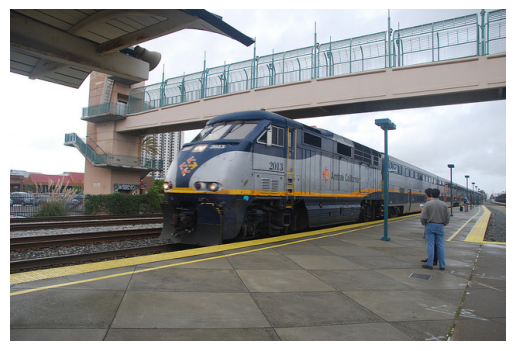

In [10]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread("/kaggle/input/coco-2017-dataset/coco2017/train2017/000000461973.jpg")
def show_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
# Example usage
show_image(im)

In [11]:
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
# cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# cfg.MODEL.WEIGHTS = os.path.join("/kaggle/input/weightretinatest/model_final.pth")
# predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [12]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([1, 5], device='cuda:0')
Boxes(tensor([[1.1418e-01, 2.3545e+02, 3.7591e+01, 2.5432e+02],
        [1.8717e+02, 1.2914e+02, 6.0046e+02, 3.0705e+02]], device='cuda:0'))


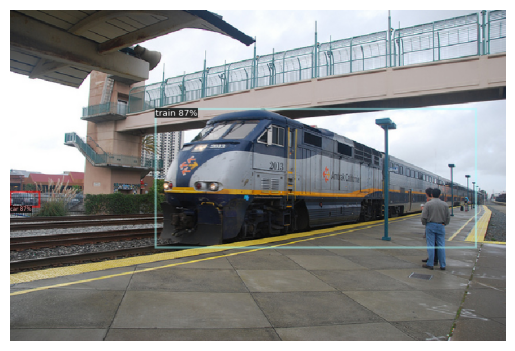

In [13]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])